## Prediction Model

In this step, the model is built to predict future customer churn. With this large amount of variables, I will apply 2 models: Logistic Regression Model & Support Vector Machine (SVM) model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from pycaret.classification import *

In [2]:
data = pd.read_csv(r'Data\Bank Churners (cleaned).csv')
data

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,0,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,1,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,1,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,1,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [3]:
df = data.copy()

In [4]:
df = df.drop(['CLIENTNUM'], axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

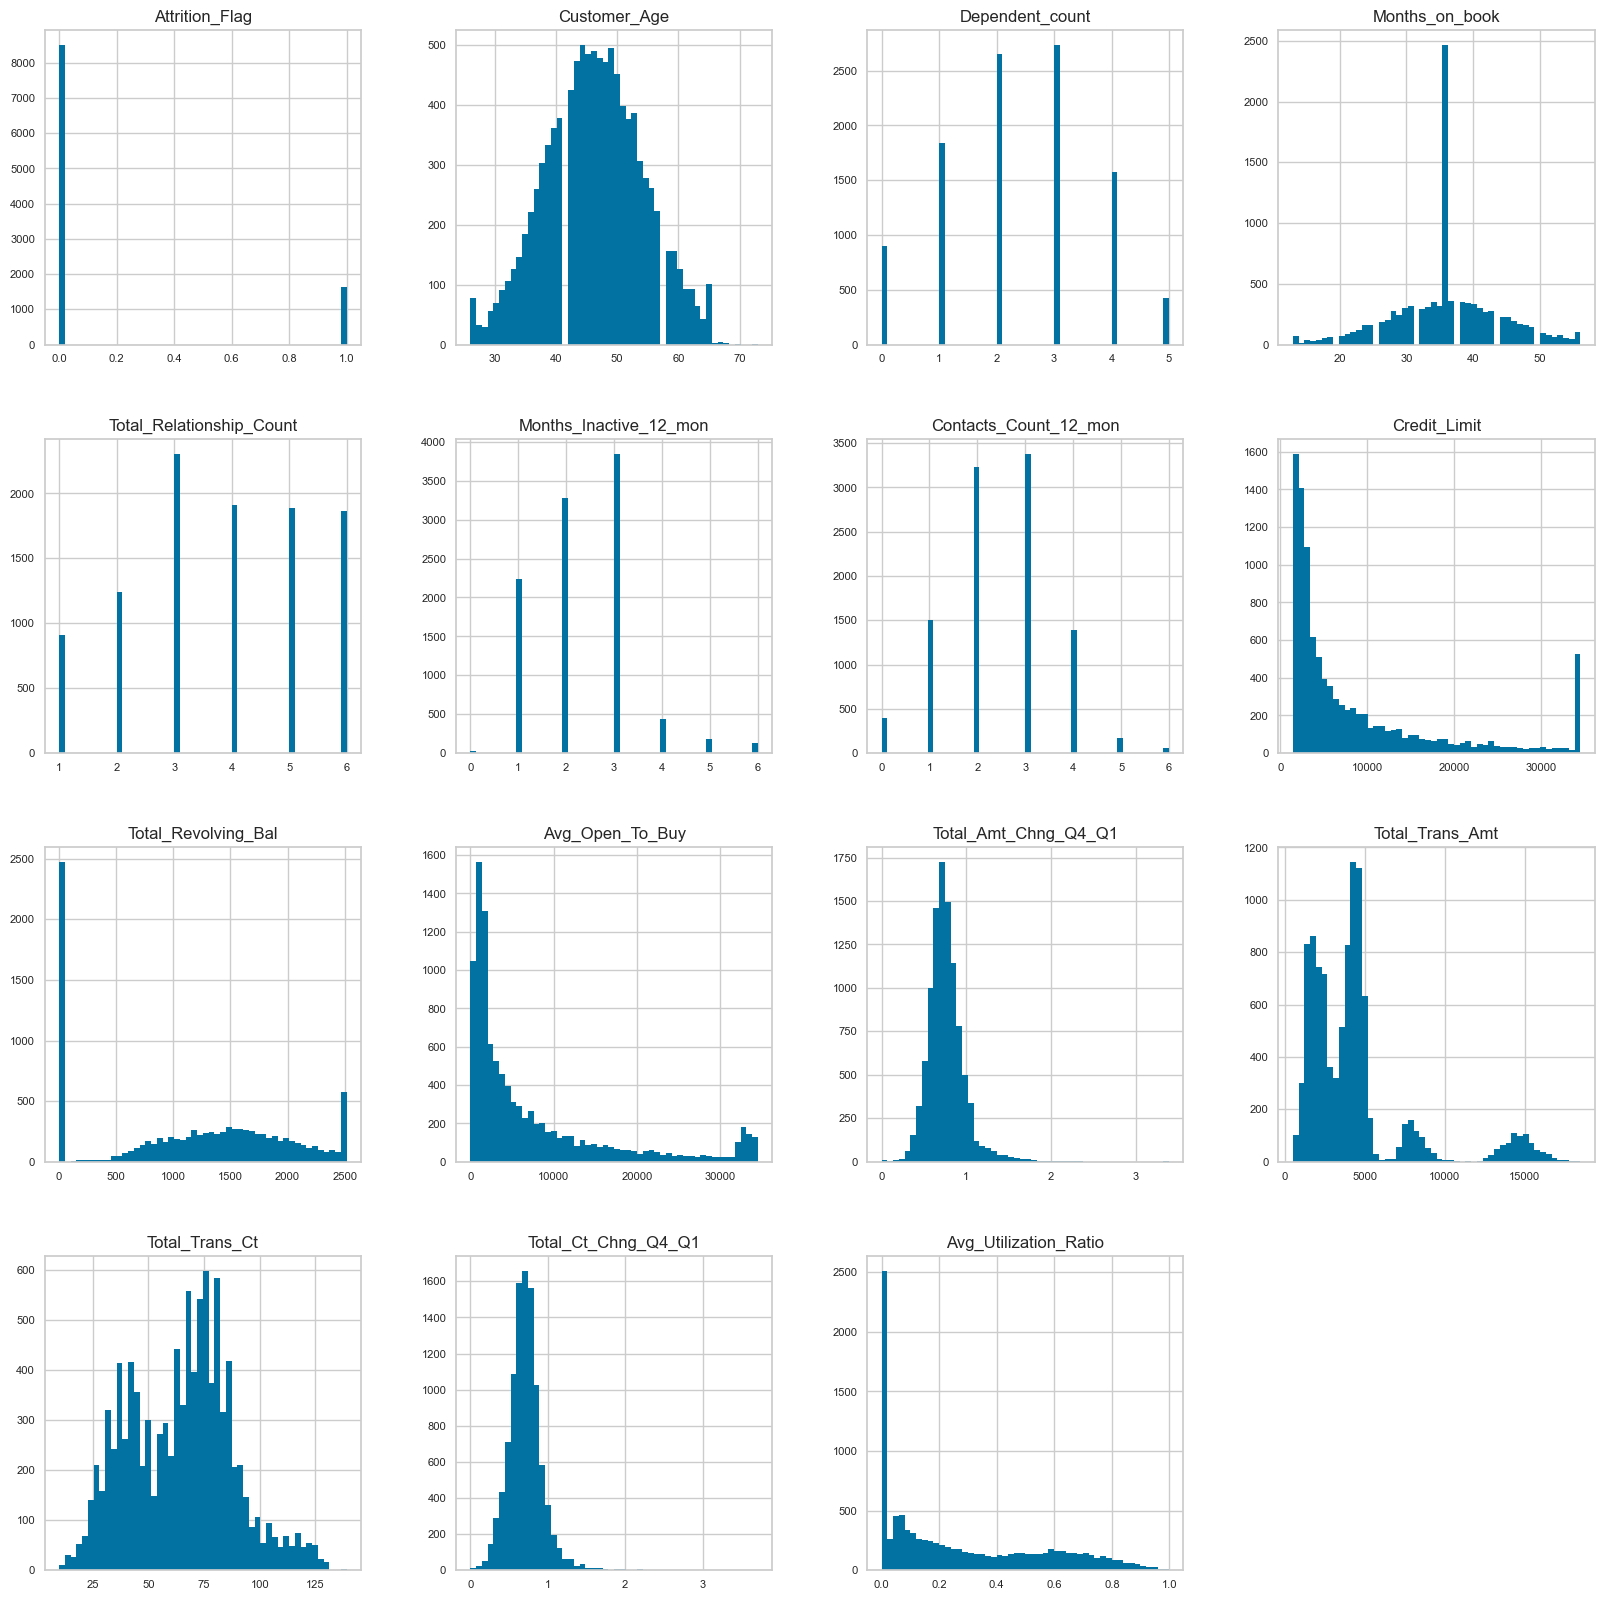

In [5]:
df.hist(figsize= (20, 20), bins= 50, xlabelsize= 8, ylabelsize= 8)
plt.show()

### Outliners

<AxesSubplot: >

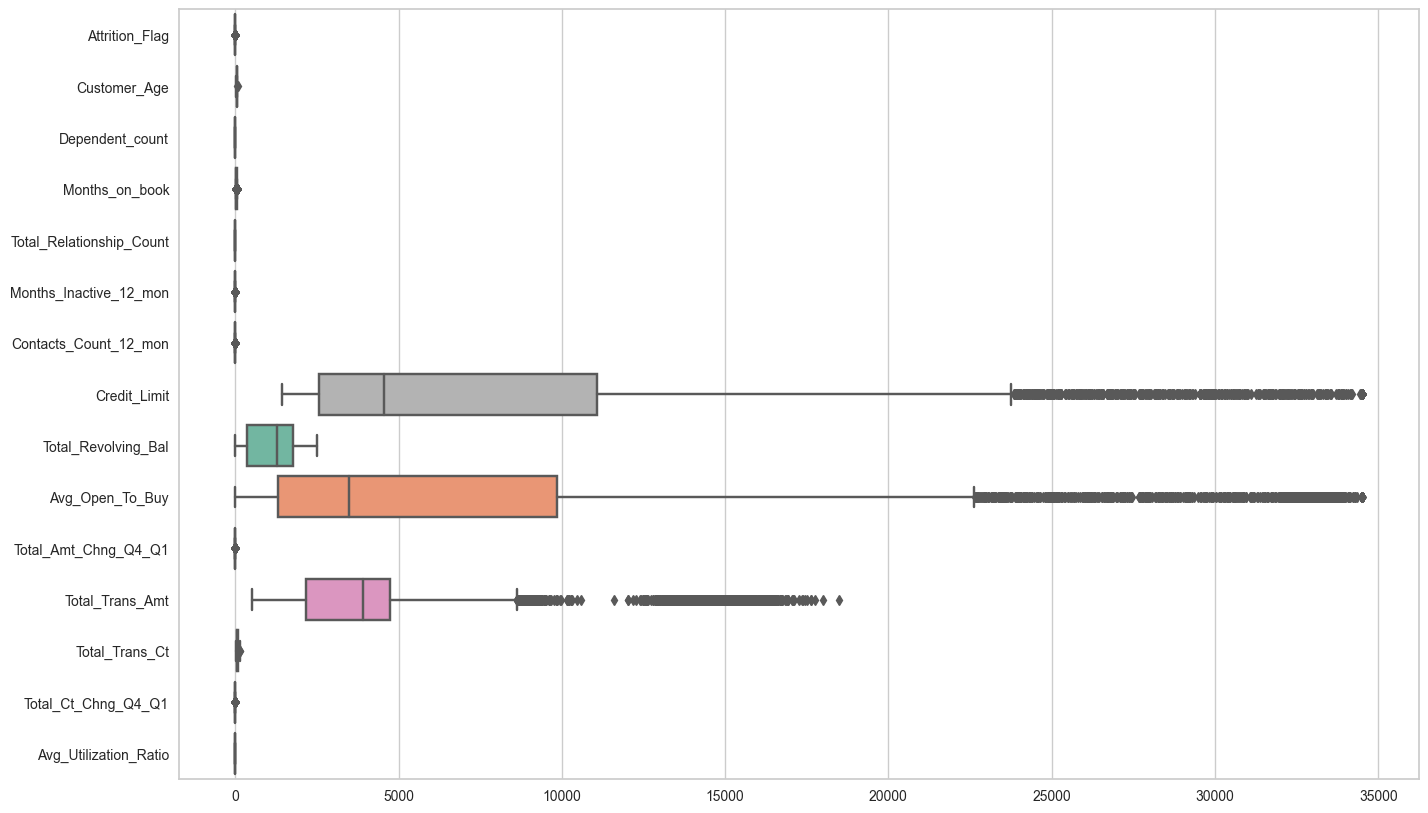

In [6]:
plt.figure(figsize=(16, 10))
sns.boxplot(df, orient= 'h', palette= 'Set2')

It seems that there are lots of existing outliners in this dataset that seems suspicious. We have to look further into the phenomenon to decide what happens to the outliers.
* Regarding customer age, months of usage, inactive months, and number of contacts, they are shown exhibit relatively stable distributions on distribution graphs, which is why I will choose to include all of them in my analysis.
* The others, on the other hand, need additional verification because they contain significant outliers, which may affect the validity of the analysis.

In [7]:
def check_outliers(data, column):
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    iqr = q3 - q1

    lower_bound = q1 - iqr * 1.5
    upper_bound = q3 + iqr * 1.5

    result = np.sum((data[column] < lower_bound) | (data[column] > upper_bound))

    print(f'Number of outliers in the column {column}:', result)

In [8]:
check_outliers(df, 'Credit_Limit')
check_outliers(df, 'Avg_Open_To_Buy')
check_outliers(df, 'Total_Amt_Chng_Q4_Q1')
check_outliers(df, 'Total_Trans_Ct')
check_outliers(df, 'Total_Ct_Chng_Q4_Q1')

Number of outliers in the column Credit_Limit: 984
Number of outliers in the column Avg_Open_To_Buy: 963
Number of outliers in the column Total_Amt_Chng_Q4_Q1: 396
Number of outliers in the column Total_Trans_Ct: 2
Number of outliers in the column Total_Ct_Chng_Q4_Q1: 394


<AxesSubplot: >

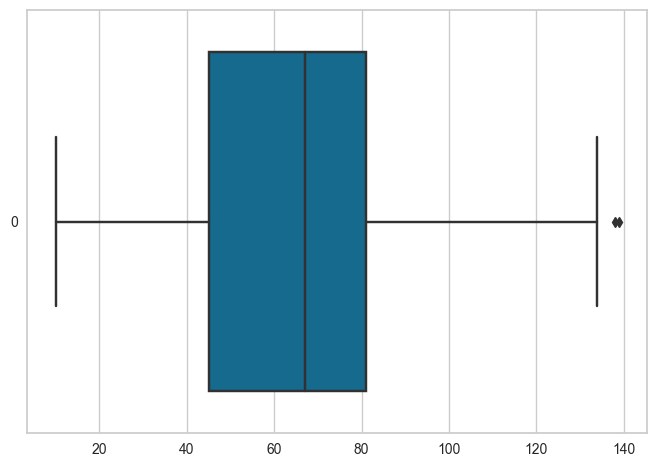

In [9]:
# Since only 'Total_Trans_Ct' contain few outliners, let's visualise it to decide whether we should remove it or not
sns.boxplot(df['Total_Trans_Ct'], orient= 'h')

Conclusion: keep all outliers.
* 'Customer_Age', 'Months_on_book', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon' are shown to be usable in both above distribution graphs and the customer analysis of the last step (data visualisation on Power BI)
* All other variables show a considerable number of variables, that may invalidate the model if removed, so they will also be included.
* Column 'Total_Trans_Ct' has only 2 outliners, but they are close to the distribution, so they will also be included.

### Balance verification

In this step, we will be checking and solving the issue of biased data, with the under represented class '1'.

In [10]:
df['Attrition_Flag'] = df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1}).astype('int')
df['Attrition_Flag'].value_counts()

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

In [11]:
encoded_df = df.copy()
encoded_df

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,1,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,1,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,1,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [12]:
def woe_encoding(data, cate_variable, target_variable):

    data_agg = data.groupby(cate_variable)[target_variable].agg(['count', 'sum'])

    data_agg.columns = ['total', '1']
    data_agg['0'] = data_agg['total'] - data_agg['1']

    total_0 = data_agg['0'].sum()
    total_1 = data_agg['1'].sum()

    data_agg['% of Class 0'] = data_agg['0'] / total_0
    data_agg['% of Class 1'] = data_agg['1'] / total_1
    data_agg['WOE'] = np.log(data_agg['% of Class 0'] / data_agg['% of Class 1'])
    data_agg.reset_index(inplace= True)

    woe_dict = dict(zip(data_agg[cate_variable], data_agg['WOE']))
    data[cate_variable] = data[cate_variable].map(woe_dict)

    return data

In [13]:
woe_encoding(encoded_df, 'Gender', 'Attrition_Flag')
woe_encoding(encoded_df, 'Education_Level', 'Attrition_Flag')
woe_encoding(encoded_df, 'Marital_Status', 'Attrition_Flag')
woe_encoding(encoded_df, 'Income_Category', 'Attrition_Flag')
woe_encoding(encoded_df, 'Card_Category', 'Attrition_Flag')

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,0.111776,3,0.065579,0.071351,0.205777,-0.002368,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,-0.092810,5,0.037320,-0.063543,-0.080839,-0.002368,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,0.111776,3,0.037320,0.071351,0.022454,-0.002368,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,-0.092810,4,0.065579,-0.083421,-0.080839,-0.002368,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,0.111776,3,0.009510,0.071351,0.205777,-0.002368,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,0.111776,2,0.037320,-0.063543,0.070360,-0.002368,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,1,41,0.111776,2,-0.057261,-0.008172,0.070360,-0.002368,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,1,44,-0.092810,1,0.065579,0.071351,-0.080839,-0.002368,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,1,30,0.111776,2,0.037320,-0.083421,0.070360,-0.002368,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [14]:
# Oversample data
X = encoded_df.iloc[:, 1:]
y = encoded_df.iloc[:, 0]
X_resampled, y_resampled = SMOTE().fit_resample(X,y)
resampled_encoded_df = pd.concat([X_resampled, y_resampled], axis=1)

### Correlation Between Variables

In this step, we will check the correlation between the dependent variable and independent variables, in order to find suitable variables for the binary classificaton model, while also checking multicollinearity.

Since Information Value was performed in the previous step and the result shows that all categorical variables have predictive power, there's no need for them to appear on correlation matrix.

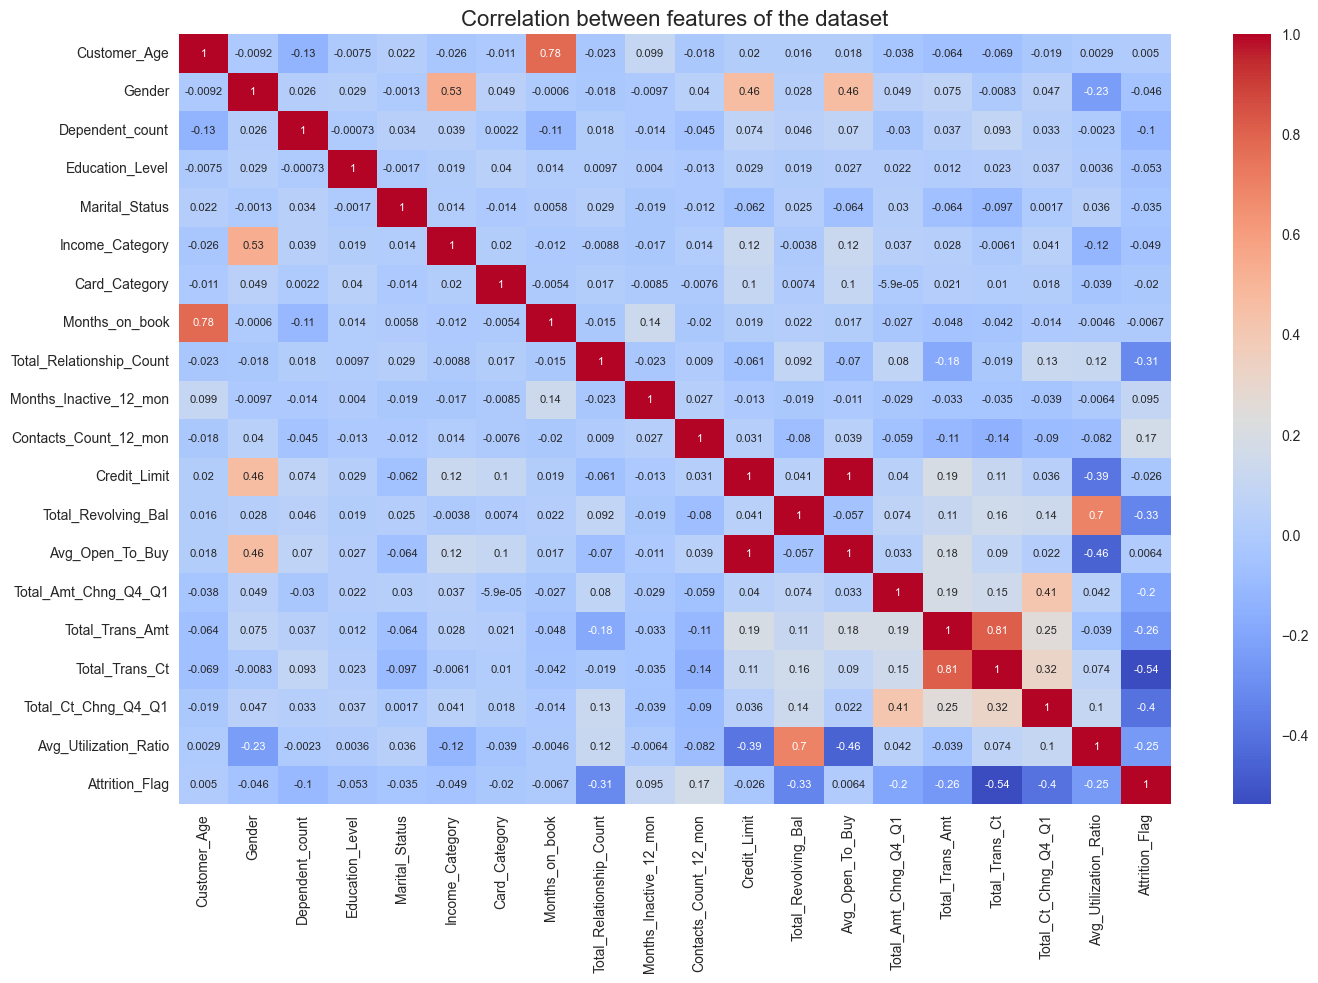

In [15]:
plt.figure(figsize= (16,10))
sns.heatmap(resampled_encoded_df.corr(), annot= True, cmap= 'coolwarm', annot_kws= {'fontsize': 8})
plt.title('Correlation between features of the dataset', size= 16)
plt.show()

Conclusion:
* 3 most insignificant contiuous variables are: 'Customer_Age', 'Months_on_book', and 'Avg_Open to_Buy'. This correlates with the z-test results in the previous steps, and they will be excluded from the final models.
* 'Dependent_count' and 'Months_on_book' will also be excluded from the models. These continuous variables demonstrate little correlation to 'Attrition_Flag', and 'Dependent_count' also have the result of the z-test that the two customer classes are the same.
* All categorical variables ('Gender', 'Education_Level', 'Marital_Status', 'Income_Category','Card_Category') will not be included in the prediction models. Both the IV test result and the correlation value exhibit the same outcome: they have little to no use, statistically, in the prediction, even though the visual representation of these variables may show some differences of the 2 customers types.
* While there may be little multicollinearity issues, the result shows that the most relationships of the variables are non-linear. Thus, it is fairly acceptable to assume that the ML models for data non-linear relationships is likely to perform better.

### Model Preparation

In [16]:
resampled_encoded_df = resampled_encoded_df.drop(['Customer_Age', 'Gender', 'Dependent_count',
                                                      'Education_Level', 'Marital_Status', 'Income_Category',
                                                      'Card_Category', 'Months_on_book', 'Avg_Open_To_Buy'], axis= 1)
X = resampled_encoded_df.iloc[:, :-1]
y = resampled_encoded_df.iloc[:, -1]

In [17]:
print(X.shape)
print(y.shape)

(17000, 10)
(17000,)


In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.2, random_state= 0)

### Model Selection with PyCaret

In [20]:
resampled_encoded_scaled_df = pd.concat([pd.DataFrame(X_scaled, columns= X.columns), pd.DataFrame(y)], axis= 1)

In [21]:
setup(resampled_encoded_scaled_df, target='Attrition_Flag', train_size= 0.8)

,Description,Value
0,Session id,7800
1,Target,Attrition_Flag
2,Target type,Binary
3,Original data shape,"(17000, 11)"
4,Transformed data shape,"(17000, 11)"
5,Transformed train set shape,"(13600, 11)"
6,Transformed test set shape,"(3400, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [22]:
best_model = compare_models(fold= 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9752,0.9967,0.9829,0.9680,0.9754,0.9504,0.9506,0.3940
lightgbm,Light Gradient Boosting Machine,0.9739,0.9964,0.9828,0.9656,0.9741,0.9478,0.9480,0.2860
rf,Random Forest Classifier,0.9721,0.9954,0.9822,0.9628,0.9724,0.9443,0.9445,0.7460
et,Extra Trees Classifier,0.9707,0.9959,0.9781,0.9638,0.9709,0.9413,0.9414,0.2560
gbc,Gradient Boosting Classifier,0.9595,0.9926,0.9671,0.9526,0.9598,0.9190,0.9191,0.8680
dt,Decision Tree Classifier,0.9458,0.9458,0.9537,0.9389,0.9462,0.8916,0.8917,0.0400
ada,Ada Boost Classifier,0.9446,0.9880,0.9488,0.9408,0.9448,0.8891,0.8892,0.2340
knn,K Neighbors Classifier,0.9356,0.9753,0.9703,0.9074,0.9378,0.8712,0.8734,0.9620
qda,Quadratic Discriminant Analysis,0.8782,0.9504,0.8871,0.8717,0.8793,0.7565,0.7566,0.0200
ridge,Ridge Classifier,0.8551,0.0000,0.8699,0.8449,0.8572,0.7101,0.7105,0.0180


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [23]:
final_model = create_model(best_model, fold= 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9779,0.9978,0.9868,0.9697,0.9781,0.9559,0.9560
1,0.9728,0.9964,0.9757,0.9700,0.9729,0.9456,0.9456
2,0.9768,0.9966,0.9875,0.9669,0.9771,0.9537,0.9539
3,0.9765,0.9971,0.9816,0.9716,0.9766,0.9529,0.9530
4,0.9721,0.9957,0.9831,0.9619,0.9724,0.9441,0.9443
Mean,0.9752,0.9967,0.9829,0.9680,0.9754,0.9504,0.9506
Std,0.0023,0.0007,0.0042,0.0034,0.0023,0.0047,0.0047


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

It seems like XGBoost is the most efficient model for this case. However, this evaluation has yet to take into account different parameters. I'm performing XGBoost, along with Logistic Regression and Support Vector Machine, to fine tune the models better.

### Logistic Regression Model

In [25]:
# Find optimal parameters using GridSearchCV
warnings.filterwarnings('ignore')
parameters = {
    'penalty': ['l1','l2'], 
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
}

logreg = LogisticRegression()

logreg_grid_search = GridSearchCV(logreg, parameters, cv= 5)
logreg_grid_search.fit(X_train, y_train)

print('Best Parameters for Logistic Regression:', logreg_grid_search.best_params_)
print('Best Score of Logistic Regression:', logreg_grid_search.best_score_)

Best Parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score of Logistic Regression: 0.8524264705882352


In [26]:
logreg = LogisticRegression(**logreg_grid_search.best_params_, multi_class= 'ovr')

# Perform k-fold cross-validation and evaluate the model
k_fold = KFold(n_splits= 5, shuffle= True, random_state= 0)
cross_val_scores = cross_val_score(logreg, X, y, cv= k_fold)
print('Cross-Validation Scores of Logistic Regression:', cross_val_scores)
print('Mean CV Accuracy:', cross_val_scores.mean())
print('Standard Deviation of CV Accuracy:', cross_val_scores.std())

Cross-Validation Scores of Logistic Regression: [0.78823529 0.78264706 0.78794118 0.78647059 0.77411765]
Mean CV Accuracy: 0.7838823529411766
Standard Deviation of CV Accuracy: 0.005272504903599177


In [27]:
logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
y_pred_logreg = logreg.predict(X_test)

In [29]:
report_logreg = classification_report(y_test, y_pred_logreg)
print('Classification Report:\n', report_logreg)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1707
           1       0.84      0.88      0.86      1693

    accuracy                           0.85      3400
   macro avg       0.85      0.85      0.85      3400
weighted avg       0.85      0.85      0.85      3400



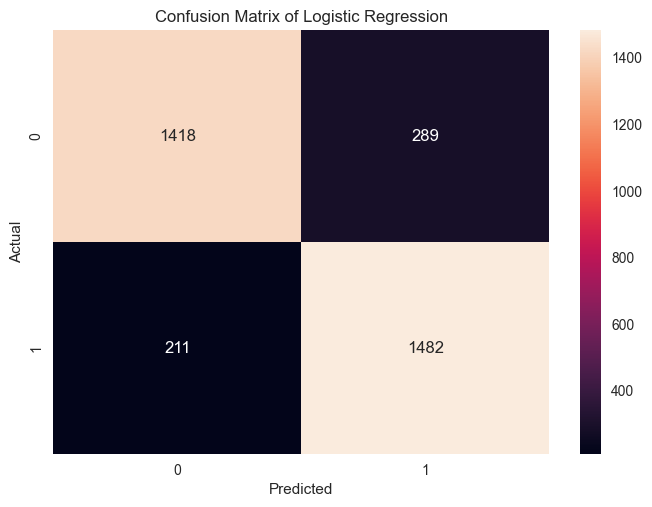

In [30]:
matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(matrix_logreg, annot= True, fmt= 'g')
plt.title(label= 'Confusion Matrix of Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

AUC score of Logistic Regression:  0.9284825244441861


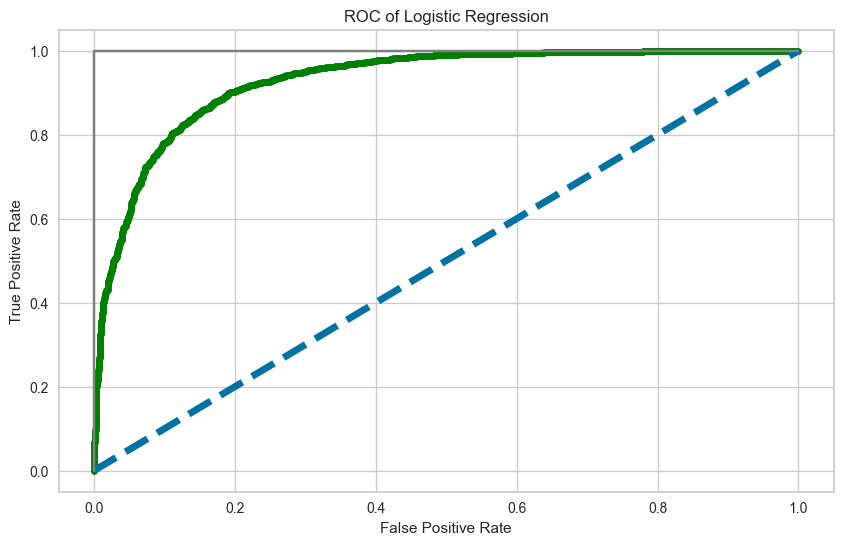

In [31]:
# Show AUC score and ROC curve
y_pred_proba_logreg = logreg.predict_proba(X_test)[:, 1]

print('AUC score of Logistic Regression: ', roc_auc_score(y_test, y_pred_proba_logreg, multi_class= 'ovr'))

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba_logreg)
plt.figure(figsize= (10, 6))
plt.title('ROC of Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate, linewidth= 5, color= 'green')
plt.plot([0,1],ls= '--',linewidth= 5)
plt.plot([0,0], [1,0], c= '0.5')
plt.plot([1,1], c= '0.5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [32]:
# Get the coefficient and intercept values
coefficients = logreg.coef_[0]
variable_names = resampled_encoded_df.columns[:-1]
coefficients_series = pd.Series(coefficients, index=variable_names)

intercept = logreg.intercept_[0]
intercept_series = pd.Series(intercept, index=['intercept'])

coefficients_and_intercept = pd.concat([coefficients_series, intercept_series])
coefficients_and_intercept

Total_Relationship_Count   -0.870304
Months_Inactive_12_mon      0.280566
Contacts_Count_12_mon       0.275894
Credit_Limit               -0.060328
Total_Revolving_Bal        -0.742443
Total_Amt_Chng_Q4_Q1       -0.187911
Total_Trans_Amt             1.609746
Total_Trans_Ct             -2.918851
Total_Ct_Chng_Q4_Q1        -0.683597
Avg_Utilization_Ratio       0.001066
intercept                  -0.051640
dtype: float64

### Support Vector Machine Model

In [33]:
# Find optimal parameters using GridSearchCV
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto']
}

svm = SVC()

svm_grid_search = GridSearchCV(svm, parameters, cv= 5)
svm_grid_search.fit(X_train, y_train)

print('Best parameters for Support Vector Machine: ', svm_grid_search.best_params_)
print('Best score of Support Vector Machine: ', svm_grid_search.best_score_)

Best parameters for Support Vector Machine:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score of Support Vector Machine:  0.953235294117647


In [34]:
svm = SVC(**svm_grid_search.best_params_, probability= True)

# Perform k-fold cross-validation and evaluate the model
k_fold = KFold(n_splits= 5, shuffle= True, random_state= 0)
cross_val_scores = cross_val_score(svm, X, y, cv= k_fold)

print('Cross-Validation Scores of Support Vector Machine:', cross_val_scores)
print('Mean CV Accuracy:', cross_val_scores.mean())
print('Standard Deviation of CV Accuracy:', cross_val_scores.std())

Cross-Validation Scores of Support Vector Machine: [0.81588235 0.82323529 0.82705882 0.83470588 0.82352941]
Mean CV Accuracy: 0.8248823529411764
Standard Deviation of CV Accuracy: 0.0061119883331108345


In [35]:
svm.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [36]:
y_pred_svm = svm.predict(X_test)

In [37]:
report_svm = classification_report(y_test, y_pred_svm)
print('Classification Report:\n', report_svm)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      1707
           1       0.94      0.97      0.96      1693

    accuracy                           0.96      3400
   macro avg       0.96      0.96      0.96      3400
weighted avg       0.96      0.96      0.96      3400



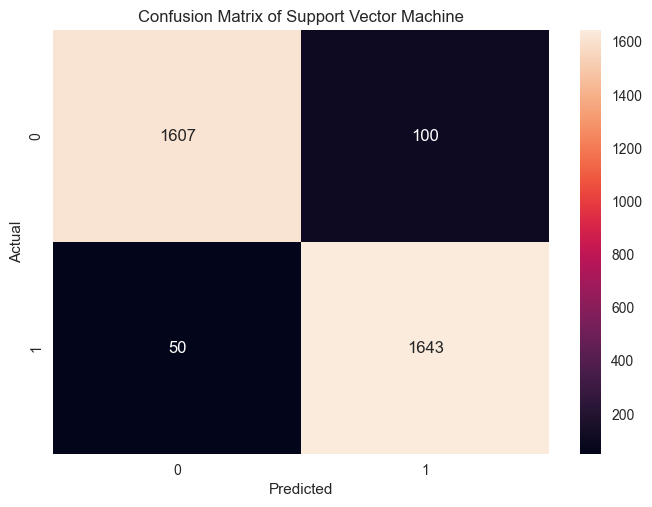

In [38]:
matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(matrix_svm, annot= True, fmt= 'g')
plt.title(label= 'Confusion Matrix of Support Vector Machine')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

AUC score of Support Vector Machine:  0.9882018760871725


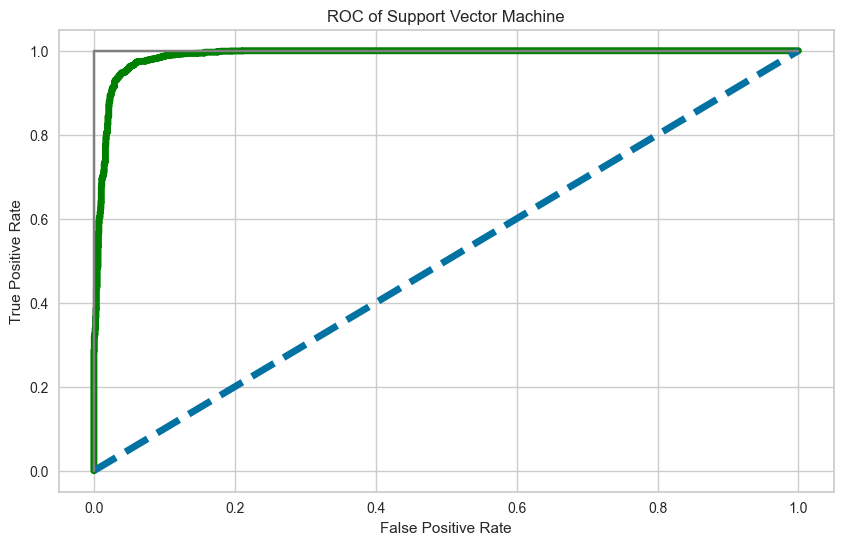

In [39]:
y_pred_proba_svm = svm.predict_proba(X_test)[:,1]

print('AUC score of Support Vector Machine: ', roc_auc_score(y_test, y_pred_proba_svm, multi_class= 'ovr'))

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba_svm)
plt.figure(figsize=(10, 6))
plt.title('ROC of Support Vector Machine')
plt.plot(false_positive_rate, true_positive_rate, linewidth= 5, color= 'green')
plt.plot([0,1],ls= '--',linewidth= 5)
plt.plot([0,0], [1,0], c= '0.5')
plt.plot([1,1], c= '0.5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### XGBoost

In [40]:
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 7, 8, 9, 10]
}

xgb = XGBClassifier(objective= 'binary:logistic')

xgb_grid_search = GridSearchCV(xgb, parameters, cv= 5)
xgb_grid_search.fit(X_train, y_train)

print('Best parameters for XGBoost: ', xgb_grid_search.best_params_)
print('Best score of XGBoost: ', xgb_grid_search.best_score_)


Best parameters for XGBoost:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Best score of XGBoost:  0.9756617647058823


In [41]:
xgb = XGBClassifier(**xgb_grid_search.best_params_, probability= True)

# Perform k-fold cross-validation and evaluate the model
k_fold = KFold(n_splits= 5, shuffle= True, random_state= 0)
cross_val_scores = cross_val_score(xgb, X, y, cv= k_fold)
print("Cross-Validation Scores for XGBoost:", cross_val_scores)
print("Mean CV Accuracy:", cross_val_scores.mean())
print("Standard Deviation of CV Accuracy:", cross_val_scores.std())

Cross-Validation Scores for XGBoost: [0.97882353 0.97676471 0.97529412 0.98176471 0.97441176]
Mean CV Accuracy: 0.9774117647058823
Standard Deviation of CV Accuracy: 0.0026398594908608295


In [42]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic', ...)

In [43]:
y_pred_xgb = xgb.predict(X_test)

In [44]:
report_xgb = classification_report(y_test, y_pred_xgb)
print('Classification Report:\n', report_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1707
           1       0.97      0.99      0.98      1693

    accuracy                           0.98      3400
   macro avg       0.98      0.98      0.98      3400
weighted avg       0.98      0.98      0.98      3400



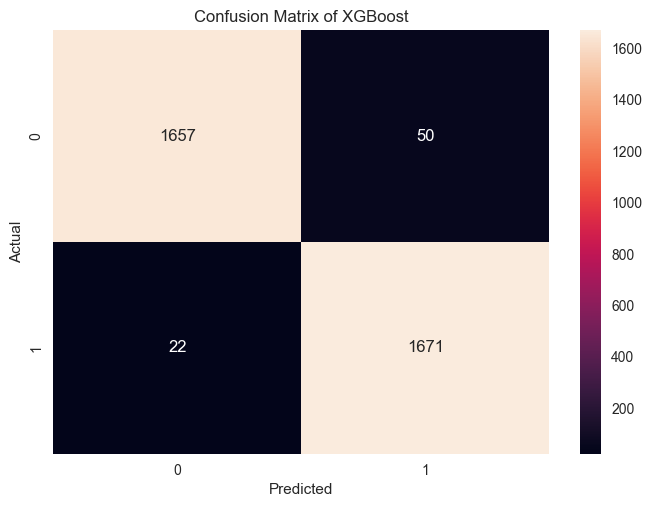

In [45]:
matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(matrix_xgb, annot= True, fmt= 'g')
plt.title(label= 'Confusion Matrix of XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

AUC score of XGBoost:  0.9960828055562188


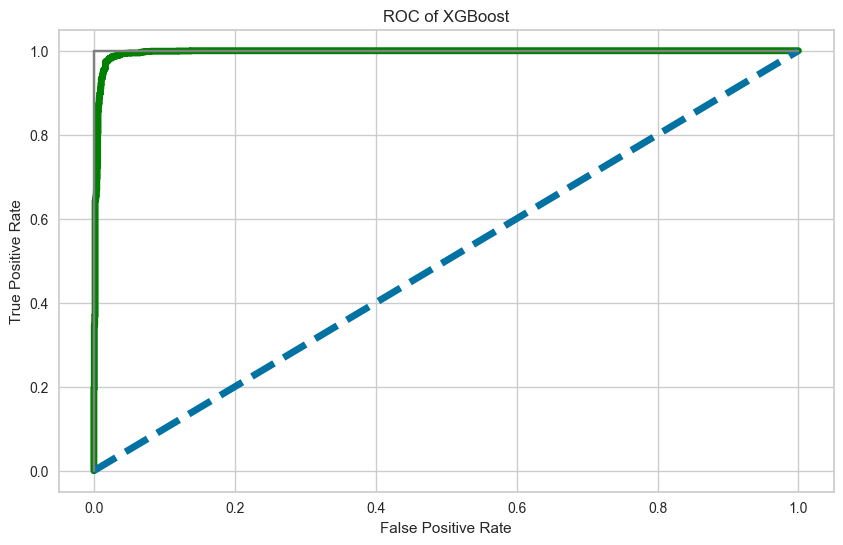

In [46]:
# Show AUC score and ROC curve
y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]

print('AUC score of XGBoost: ', roc_auc_score(y_test, y_pred_proba_xgb, multi_class= 'ovr'))

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(10, 6))
plt.title('ROC of XGBoost')
plt.plot(false_positive_rate, true_positive_rate, linewidth= 5, color= 'green')
plt.plot([0,1],ls= '--',linewidth= 5)
plt.plot([0,0], [1,0], c= '0.5')
plt.plot([1,1], c= '0.5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Save and Load Model

In [47]:
import pickle

trained_model = xgb
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(trained_model, file)

In [48]:
with open('xgb_model.pkl', 'rb') as file:
    final_model = pickle.load(file)